### 1 Tokenizer

In [1]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import numpy as np
import matplotlib.pyplot as plt

tokenizer_path = "Meta-Llama-3-8B/tokenizer.model" # Llamma3官方token化路径
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|reserved_special_token_4|>",
            "<|eot_id|>", # 结束符 end of turn 特别地定义前5个reserved_special_token，循环定义剩余的251个特殊符号
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]
mergeable_ranks = load_tiktoken_bpe(tokenizer_path) # Byte Pair Encoding (BPE) ranks from the tokenizer model
tokenizer = tiktoken.Encoding(
    name = Path(tokenizer_path).name, # 使用tokenizer文件名作为tokenizer的名字
    pat_str = r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1, 3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\s)|\s+", # 使用官方的正则表达式
    mergeable_ranks= mergeable_ranks, # 使用官方的BPE ranks
    special_tokens = {token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)}, # 使用官方的special_tokens
)
tokenizer.decode(tokenizer.encode("Hello world")) # 测试tokenizer是否正确加载


'Hello world'

#### pat_str正则化表达式解读
* *(?i:)*  
Makes the pattern case-insensitive.  
* *'s|'t|'re|'ve|'m|'ll|'d*  
Matches common English contractions: 's, 't, 're, 've, 'm, 'll, 'd.  
* *[^\r\n\p{L}\p{N}]?*  
Optionally matches a single character that is not a carriage return (\r), newline (\n), letter (\p{L}), or digit (\p{N}).  
* *\p{L}+*  
Matches one or more letters.  
* *\p{N}{1, 3}*  
Matches 1 to 3 digits.  
* *?*  
Matches an optional space.  
* *[^\s\p{L}\p{N}]+*  
Matches one or more characters that are not whitespace (\s), letters, or digits.  
* *[\r\n]\**  
Matches zero or more carriage returns or newlines.  
* *\s\**  
Matches zero or more whitespace characters.  
* *[\r\n]+*  
Matches one or more carriage returns or newlines.  
* *\s+*  
Matches one or more whitespace characters.  
* *(?!\s)*  
Ensures that the next character is not a whitespace character (negative lookahead).  
* *\s+*
Matches one or more whitespace characters.

### 2 Read the model file

In [2]:
with open("Meta-Llama-3-8B/params.json", "r") as f:
    config = json.load(f)
config

{'dim': 4096,
 'n_layers': 32,
 'n_heads': 32,
 'n_kv_heads': 8,
 'vocab_size': 128256,
 'multiple_of': 1024,
 'ffn_dim_multiplier': 1.3,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0}

In [3]:
"""
Use the model params to load the model
the model has 32 transformer layers
each multi-head attention block has 32 heads
the vocab size and so on
"""
dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

In [4]:
model = torch.load("Meta-Llama-3-8B/consolidated.00.pth")
print(json.dumps(list(model.keys())[:20], indent=4))

[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight"
]


### 3 Text 2 tokens 2 embedding

In [5]:
# text 2 tokens
# prompt = "to be or not to be, that is the question"
prompt = "To be or not to be, that is the"
tokens = [128000] + tokenizer.encode(prompt)
print(tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)

[128000, 1271, 387, 477, 539, 311, 387, 11, 430, 374, 279]
['<|begin_of_text|>', 'To', ' be', ' or', ' not', ' to', ' be', ',', ' that', ' is', ' the']


In [6]:
#convert tokens to their embedding
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"]) # model
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([11, 4096])

### rms norm

In [7]:
# def rms_norm(tensor, norm_weights):
#     rms = (tensor.pow(2).mean(-1, keepdim=True) + norm_eps)**0.5
#     return tensor * (norm_weights / rms)
def rms_norm(tensor, norm_weights):
    return (tensor * 
            torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) 
                        + norm_eps)) * norm_weights

$ x'_i = \frac{x_i}{RMS(x)} $  
where $ RMS(x) = \sqrt{\frac{1}{n}\sum_{i = 1}^{n} x_i^2} $

In [8]:
token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"])
token_embeddings.shape

torch.Size([11, 4096])

### 4 Build the first first layer of Transformer

In [10]:
print(
    model["layers.0.attention.wq.weight"].shape,
    model["layers.0.attention.wk.weight"].shape,
    model["layers.0.attention.wv.weight"].shape,
    model["layers.0.attention.wo.weight"].shape
)
# 查看原模型中self-attention的query、key、value和output权重矩阵的shape

torch.Size([4096, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([4096, 4096])


In [11]:
# unwrapping query
q_layer0 = model["layers.0.attention.wq.weight"]
head_dim = q_layer0.shape[0] // n_heads
q_layer0 = q_layer0.reshape(n_heads, head_dim, dim)
q_layer0.shape

torch.Size([32, 128, 4096])

In [12]:
# first head of the first layer
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape

torch.Size([128, 4096])

In [13]:
'''
multiply the query weights with the token embedding, to recive a query for the token
'''
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
q_per_token.shape

torch.Size([11, 128])

In [14]:
# positioning encoding
#Rotary Positional Embeddings
# use theta degree to position the token's poiton in the query
#eg: dog = 1 theta, The dog = 2 theta

q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
# split the query vectors into pairs to apply a rotational angle shift to each pair
# torch.Size([17, 64, 2])128 length queries split into 64 pairs for each token in the prompt
# each of those 64 pairs will be rotated by m*(theta) where m is the position of the token for which we are rotating the query
q_per_token_split_into_pairs.shape

torch.Size([11, 64, 2])

In [15]:
# using dot product of complex numbers to rotate a vector
zero_to_one_split_into_64_parts = torch.tensor(range(64))/64
zero_to_one_split_into_64_parts
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)
freqs

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

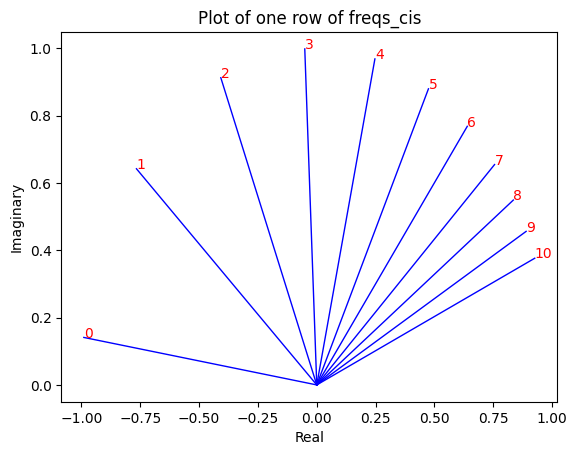

In [16]:
freqs_for_each_token = torch.outer(torch.arange(token_embeddings_unnormalized.shape[0]), freqs) # token_embeddings_unnormalized.shape[0] tokens in the prompt
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
freqs_cis.shape

# viewing the third row of freqs_cis
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:token_embeddings_unnormalized.shape[0]]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis')
plt.show()

In [17]:
# convert the query to complex numbers and then dot product to rotate the query
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
q_per_token_as_complex_numbers.shape

torch.Size([11, 64])

In [18]:
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis
q_per_token_as_complex_numbers_rotated.shape

torch.Size([11, 64])

In [19]:
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)
q_per_token_split_into_pairs_rotated.shape
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
q_per_token_rotated.shape

torch.Size([11, 128])

In [20]:
# Keys
'''
> keys generate key vectors also of dimention 128
> keys have only 1/4th the number of the weights as queries, this is because the weights for keys are shared across 4 heads at a time, to reduce the number of computations need
> keys are also rotated to add positional info, just like queries because of the same reasons
'''
k_layer0 = model["layers.0.attention.wk.weight"]
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim)
k_layer0.shape

torch.Size([8, 128, 4096])

In [21]:
k_layer0_head0 = k_layer0[0]
k_layer0_head0.shape

torch.Size([128, 4096])

In [22]:
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

#### multiply the queries and key matrices

In [23]:
'''
doing this will give us a score mapping each token with one another
this score describes how well each token's query relates to the each tokens's key. THIS IS SELF ATTENTION :)
the shape of the attention score matrix (qk_per_token) is [12x12] where 12 is the number of tokens in the prompt
'''
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
qk_per_token.shape

torch.Size([11, 11])

#### mask query key scores

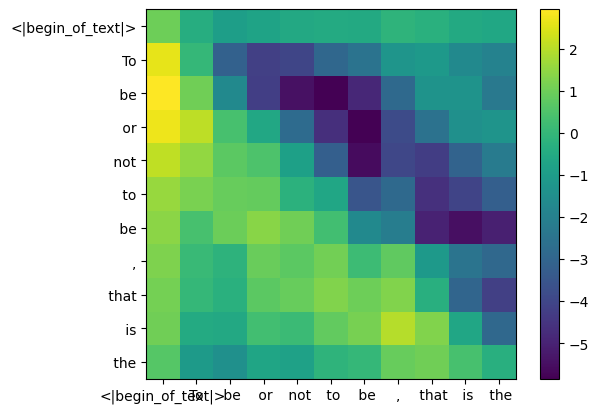

In [24]:
# we only learn to predict tokens using past tokens
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)
    
display_qk_heatmap(qk_per_token)

In [25]:
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

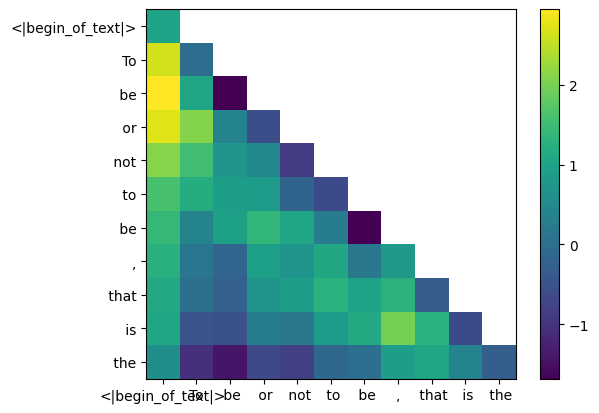

In [26]:
qk_per_token_after_masking = qk_per_token + mask
display_qk_heatmap(qk_per_token_after_masking)

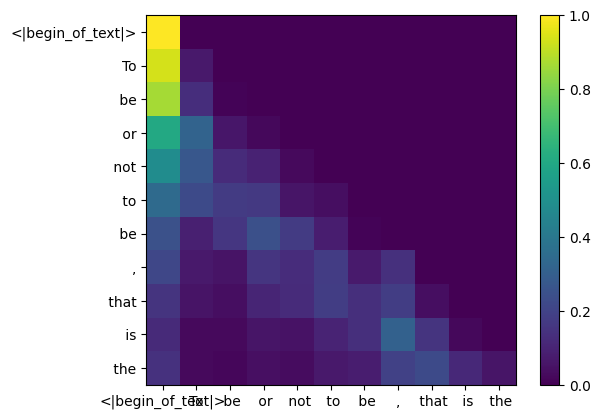

In [27]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

$ softmax(\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d_k}}) * V = Z $

#### Values

In [28]:
'''
scores (0-1) are used to determine how much of value matrix is used per token
> just like keys, value weights are also shared acorss every 4 attention heads (to save computation)
> as a result, the shape of the value weight matrix below is [8x128x4096]
'''

'\nscores (0-1) are used to determine how much of value matrix is used per token\n> just like keys, value weights are also shared acorss every 4 attention heads (to save computation)\n> as a result, the shape of the value weight matrix below is [8x128x4096]\n'

In [29]:
v_layer0 = model["layers.0.attention.wv.weight"]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
v_layer0.shape
v_layer0_head0 = v_layer0[0]
v_layer0_head0.shape

torch.Size([128, 4096])

In [30]:
# vector values
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
v_per_token.shape

torch.Size([11, 128])

In [31]:
# attention(Z) = softmax(QK^T/sqrt(d_k))V
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
qkv_attention.shape

torch.Size([11, 128])

### 5 Multihead Attention

In [32]:
# run a loop and perform the exact same math as the cells above but for every head in the first layer
qkv_attention_store = []

for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//4] # key weights are shared across 4 heads
    v_layer0_head = v_layer0[head//4] # value weights are shared across 4 heads
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)

    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)

32

In [33]:
# merge all attention scores into one large matrix
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([11, 4096])

### 6 Weight Matrix

In [34]:
w_layer0 = model["layers.0.attention.wo.weight"]
w_layer0.shape

torch.Size([4096, 4096])

In [35]:
# matmul the simple linear layer of weights
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

torch.Size([11, 4096])

In [36]:
# adding the change in the embedding value after attention, to the original token embeddings
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit.shape

torch.Size([11, 4096])

In [37]:
# rms normalization
# run a feed forward neural network through the embedding delta
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"])
embedding_after_edit_normalized.shape

torch.Size([11, 4096])

In [38]:
# loading the ff weights
# implementing the feed forward network
import torch.nn.functional as F
w1 = model["layers.0.feed_forward.w1.weight"]
w2 = model["layers.0.feed_forward.w2.weight"]
w3 = model["layers.0.feed_forward.w3.weight"]
output_after_feedforward = torch.matmul(F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

'''
in llama3, they used a SwiGLU feedforward network, 
this network architecture is really good at adding non linearity 
when needed by the model.
its pretty standard to use this feed forward network architecture 
in llms these days
'''

'''
embedding_after_edit_normalized 是输入的标准化后的嵌入向量，形状为 [12, 4096]。
w1, w2, w3 是从模型中加载的权重，假设每个权重的形状为 [input_dim, hidden_dim]。
F.silu 是 PyTorch 中的 Swish 激活函数。
torch.matmul 是 PyTorch 中的矩阵乘法函数，用于执行线性变换。
'''

'\nembedding_after_edit_normalized 是输入的标准化后的嵌入向量，形状为 [12, 4096]。\nw1, w2, w3 是从模型中加载的权重，假设每个权重的形状为 [input_dim, hidden_dim]。\nF.silu 是 PyTorch 中的 Swish 激活函数。\ntorch.matmul 是 PyTorch 中的矩阵乘法函数，用于执行线性变换。\n'

$ GLU(x) = (XW_1 + b_1)\circ \sigma(XW_2 + b_2) $  
$\sigma$表示激活函数，通常为sigmoid函数。  
  
$Swish(x) = x \cdot \sigma(\beta x) $ Swish 激活函数具有非线性且平滑的特性，能够帮助梯度流动，改善深层网络的训练。  
  
$SwiGLU(X) = (XW_1 + b_1)\circ Swish(XW_2 + b_2) $

### 7 Loop the first layer

In [39]:
layer_0_embedding = embedding_after_edit+output_after_feedforward
layer_0_embedding.shape

torch.Size([11, 4096])

In [40]:
final_embedding = token_embeddings_unnormalized
for layer in range(n_layers):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//4]
        v_layer_head = v_layer[head//4]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis)
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    final_embedding = embedding_after_edit+output_after_feedforward

In [41]:
final_embedding = rms_norm(final_embedding, model["norm.weight"])
final_embedding.shape

torch.Size([11, 4096])

### 8 Decode the embedding into the token value

In [42]:
model["output.weight"].shape

torch.Size([128256, 4096])

use the embedding of the last token to predict the next value

In [43]:
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)
logits.shape

torch.Size([128256])

the model predicted token number above as the next token, is this the token number for your predicted word?

In [44]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(3488)

In [45]:
tokenizer.decode([next_token.item()])

' question'

The output above shows that prediction of Llama3.

#### Congratulations! The llama finally works